# Visión por Computadora 2 - TP Final

**Integrantes:**
* Gustavo Ramoscelli
* Martín Errázquin

**Objetivo:** Clasificación de enfermedades en hojas de plantas.

**Dataset a utilizar:** [PlantVillage Dataset](https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset/data). Como consiste en 3 subcarpetas (color, grayscale, segmented) las cuales son imágenes originales, versión en escala de grises y versión con fondo eliminado se decidió trabajar solamente con la versión a color, que son las originales. Se consideró que de las tres opciones, esta es la más aplicable a un caso de uso real al no disponer del algoritmo utilizado para la segmentación.

**Experimento 2:** entrenamiento de CNN simple.

# Preliminaries

## Installs

In [1]:
!pip install supervision -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 2.6 MB/s eta 0:00:00


## Imports

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
import zipfile
from collections import Counter, defaultdict
from pathlib import Path
from PIL import Image
#from sklearn.cluster import KMeans
#from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from google.colab import drive
from numpy.random import default_rng
import supervision as sv
import time

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.v2 import RandomHorizontalFlip, RandomVerticalFlip, Compose
from torch.optim import SGD, AdamW
from torch.optim.lr_scheduler import StepLR
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms.v2.functional import convert_image_dtype, to_pil_image
from torchvision.models import EfficientNet_B0_Weights, efficientnet_b0

from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay


## Utils

In [3]:
# generalizacion de train_test_split stratified de sklearn
def stratified_split(y: pd.Series, sizes: list[float], seed: int = 42) -> list[int]:
    if not np.isclose(sum(sizes), 1.0):
        raise ValueError("Sizes must sum to 1.")
    if not all(0 < s < 1 for s in sizes):
        raise ValueError("All sizes must be in the interval (0, 1).")

    split_assignment = np.empty(len(y), dtype=int)

    rng = default_rng(seed)

    class_to_indices = defaultdict(list)
    for idx, label in y.items():
        class_to_indices[label].append(idx)

    for indices in class_to_indices.values():
        indices = np.array(indices)
        rng.shuffle(indices)
        n = len(indices)

        split_sizes = [int(s * n) for s in sizes]
        split_sizes[-1] = n - sum(split_sizes[:-1])

        start = 0
        for split_idx, size in enumerate(split_sizes):
            end = start + size
            split_assignment[indices[start:end]] = split_idx
            start = end

    return split_assignment.tolist()

## Data loading

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
DRIVE_PATH = Path('/content/drive/MyDrive')

assert DRIVE_PATH.exists(), "Drive is not mounted"

In [6]:
USER = 'Martin' # 'Gustavo'

PATHS = {
    'Martin': 'posgrado/CEIA/vpc2/VPC 2/dataset_zipped/dataset.zip',
    'Gustavo': 'TODO'
}

dataset_zipped_path = DRIVE_PATH / PATHS[USER]

assert dataset_zipped_path.exists() and dataset_zipped_path.is_file()

In [7]:
DATASET_DIR = Path('./dataset')

DATASET_DIR.mkdir(exist_ok=True)

if len(list(DATASET_DIR.iterdir()))==0:
    with zipfile.ZipFile(dataset_zipped_path, 'r') as zip_ref:
        zip_ref.extractall(DATASET_DIR)
        print("Unzipped!")
else:
    print("Already unzipped")

Unzipped!


In [8]:
IMGS_DIR = DATASET_DIR / 'color'

In [9]:
folder_df = pd.DataFrame([
    {'name': p.name, 'n_imgs': len(list(p.iterdir()))}
    for p in IMGS_DIR.iterdir()
]).sort_values('name').reset_index(drop=True)

folder_df

,name,n_imgs
0,Apple___Apple_scab,630
1,Apple___Black_rot,621
2,Apple___Cedar_apple_rust,275
3,Apple___healthy,1645
4,Blueberry___healthy,1502
5,Cherry_(including_sour)___Powdery_mildew,1052
6,Cherry_(including_sour)___healthy,854
7,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,513
8,Corn_(maize)___Common_rust_,1192
9,Corn_(maize)___Northern_Leaf_Blight,985


In [10]:
N_CLASSES = len(folder_df)

print(f"Hay {N_CLASSES} clases")

Hay 38 clases


In [11]:
folder_df[['fruit','disease']] = folder_df['name'].str.split('___', regex=False, expand=True)

folder_df

,name,n_imgs,fruit,disease
0,Apple___Apple_scab,630,Apple,Apple_scab
1,Apple___Black_rot,621,Apple,Black_rot
2,Apple___Cedar_apple_rust,275,Apple,Cedar_apple_rust
3,Apple___healthy,1645,Apple,healthy
4,Blueberry___healthy,1502,Blueberry,healthy
5,Cherry_(including_sour)___Powdery_mildew,1052,Cherry_(including_sour),Powdery_mildew
6,Cherry_(including_sour)___healthy,854,Cherry_(including_sour),healthy
7,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,513,Corn_(maize),Cercospora_leaf_spot Gray_leaf_spot
8,Corn_(maize)___Common_rust_,1192,Corn_(maize),Common_rust_
9,Corn_(maize)___Northern_Leaf_Blight,985,Corn_(maize),Northern_Leaf_Blight


In [12]:
img_df = pd.DataFrame([
    {
        'label': class_p.name,
        'img_path': str(img_p),
    }
    for class_p in sorted(IMGS_DIR.iterdir())
    for img_p in sorted(class_p.iterdir())
])


img_df

,label,img_path
0,Apple___Apple_scab,dataset/color/Apple___Apple_scab/00075aa8-d81a...
1,Apple___Apple_scab,dataset/color/Apple___Apple_scab/01a66316-0e98...
2,Apple___Apple_scab,dataset/color/Apple___Apple_scab/01f3deaa-6143...
3,Apple___Apple_scab,dataset/color/Apple___Apple_scab/0208f4eb-45a4...
4,Apple___Apple_scab,dataset/color/Apple___Apple_scab/023123cb-7b69...
...,...,...
54300,Tomato___healthy,dataset/color/Tomato___healthy/ff354b62-5981-4...
54301,Tomato___healthy,dataset/color/Tomato___healthy/ff774aec-2504-4...
54302,Tomato___healthy,dataset/color/Tomato___healthy/ff8b36d5-feaf-4...
54303,Tomato___healthy,dataset/color/Tomato___healthy/ffb39943-eabb-4...


In [13]:
CLASS2IDX = {cls:idx for idx,cls in enumerate(folder_df.name.values)}
IDX2CLASS = {v:k for k,v in CLASS2IDX.items()}

CLASS2IDX.items()

dict_items([('Apple___Apple_scab', 0), ('Apple___Black_rot', 1), ('Apple___Cedar_apple_rust', 2), ('Apple___healthy', 3), ('Blueberry___healthy', 4), ('Cherry_(including_sour)___Powdery_mildew', 5), ('Cherry_(including_sour)___healthy', 6), ('Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 7), ('Corn_(maize)___Common_rust_', 8), ('Corn_(maize)___Northern_Leaf_Blight', 9), ('Corn_(maize)___healthy', 10), ('Grape___Black_rot', 11), ('Grape___Esca_(Black_Measles)', 12), ('Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 13), ('Grape___healthy', 14), ('Orange___Haunglongbing_(Citrus_greening)', 15), ('Peach___Bacterial_spot', 16), ('Peach___healthy', 17), ('Pepper,_bell___Bacterial_spot', 18), ('Pepper,_bell___healthy', 19), ('Potato___Early_blight', 20), ('Potato___Late_blight', 21), ('Potato___healthy', 22), ('Raspberry___healthy', 23), ('Soybean___healthy', 24), ('Squash___Powdery_mildew', 25), ('Strawberry___Leaf_scorch', 26), ('Strawberry___healthy', 27), ('Tomato___Bacterial_spot', 

In [14]:
img_df['label_idx'] = img_df['label'].map(CLASS2IDX)

img_df

,label,img_path,label_idx
0,Apple___Apple_scab,dataset/color/Apple___Apple_scab/00075aa8-d81a...,0
1,Apple___Apple_scab,dataset/color/Apple___Apple_scab/01a66316-0e98...,0
2,Apple___Apple_scab,dataset/color/Apple___Apple_scab/01f3deaa-6143...,0
3,Apple___Apple_scab,dataset/color/Apple___Apple_scab/0208f4eb-45a4...,0
4,Apple___Apple_scab,dataset/color/Apple___Apple_scab/023123cb-7b69...,0
...,...,...,...
54300,Tomato___healthy,dataset/color/Tomato___healthy/ff354b62-5981-4...,37
54301,Tomato___healthy,dataset/color/Tomato___healthy/ff774aec-2504-4...,37
54302,Tomato___healthy,dataset/color/Tomato___healthy/ff8b36d5-feaf-4...,37
54303,Tomato___healthy,dataset/color/Tomato___healthy/ffb39943-eabb-4...,37


In [15]:
# re-mostramos la distribución de clases
(img_df.label.value_counts(normalize=True)*100).round(3)

,proportion
label,
Orange___Haunglongbing_(Citrus_greening),10.141
Tomato___Tomato_Yellow_Leaf_Curl_Virus,9.865
Soybean___healthy,9.373
Peach___Bacterial_spot,4.230
Tomato___Bacterial_spot,3.917
Tomato___Late_blight,3.515
Squash___Powdery_mildew,3.379
Tomato___Septoria_leaf_spot,3.261
Tomato___Spider_mites Two-spotted_spider_mite,3.086


Nuevamente, se debe recordar que hay un fuerte desbalance entre las clases más populares y las menos. La clase papa sana no llega a 0.3% del dataset. Para 38 clases, si el mismo estuviera balanceado deberían ser aprox. 2.63%. Esto indefectiblemente va a afectar la performance del modelo sobre clases raras.

## Config

In [16]:
# seed para splitting
RNG_SEED = 42

# Proporciones de train-validation-test para splits
SPLIT_SIZES = [0.7,0.1,0.2]

# transformaciones para Data Augmentation
TRANSFORMS = None #[RandomHorizontalFlip(0.5), RandomVerticalFlip(0.5)]

# batch sizes
BATCH_SZ_TRAIN = 2**7
BATCH_SZ_VALID = 2**7
BATCH_SZ_TEST = 2**7

# epochs
EPOCHS = 10

# learning rate
LR = 3e-4

# weight decay
W_DECAY = 0 #1e-2

# momentum alpha
#MOMENTUM = 0.9

## Train-valid-test splitting

Hacemos un split 70-10-20. Al ser un dataset grande, de 54k observaciones, un split de 10% tiene casi 5500 imágenes.

In [17]:
img_df['split_idx'] = stratified_split(img_df['label_idx'], SPLIT_SIZES)

img_df

,label,img_path,label_idx,split_idx
0,Apple___Apple_scab,dataset/color/Apple___Apple_scab/00075aa8-d81a...,0,0
1,Apple___Apple_scab,dataset/color/Apple___Apple_scab/01a66316-0e98...,0,2
2,Apple___Apple_scab,dataset/color/Apple___Apple_scab/01f3deaa-6143...,0,0
3,Apple___Apple_scab,dataset/color/Apple___Apple_scab/0208f4eb-45a4...,0,0
4,Apple___Apple_scab,dataset/color/Apple___Apple_scab/023123cb-7b69...,0,1
...,...,...,...,...
54300,Tomato___healthy,dataset/color/Tomato___healthy/ff354b62-5981-4...,37,1
54301,Tomato___healthy,dataset/color/Tomato___healthy/ff774aec-2504-4...,37,0
54302,Tomato___healthy,dataset/color/Tomato___healthy/ff8b36d5-feaf-4...,37,0
54303,Tomato___healthy,dataset/color/Tomato___healthy/ffb39943-eabb-4...,37,0


In [18]:
img_df.split_idx.value_counts(normalize=True).sort_index()

,proportion
split_idx,
0,0.699696
1,0.099751
2,0.200552


In [19]:
class ImageDataset(Dataset):

    def __init__(self, df, transforms = None):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row_dict = self.df.iloc[idx].to_dict()

        str_dir = row_dict['img_path']
        target = row_dict['label_idx']

        img = read_image(str_dir, mode=ImageReadMode.RGB)
        img = convert_image_dtype(img, dtype=torch.float)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

In [20]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [21]:
splits = {
    split_name:(
        img_df
        .drop(columns=['split_idx','label'])
        .loc[img_df['split_idx']==split_idx]
        .reset_index(drop=True)
    )
    for split_idx, split_name
    in enumerate(['train','valid','test'])
}

splits['train']

,img_path,label_idx
0,dataset/color/Apple___Apple_scab/00075aa8-d81a...,0
1,dataset/color/Apple___Apple_scab/01f3deaa-6143...,0
2,dataset/color/Apple___Apple_scab/0208f4eb-45a4...,0
3,dataset/color/Apple___Apple_scab/029424b0-0ef5...,0
4,dataset/color/Apple___Apple_scab/03354abb-aa1c...,0
...,...,...
37992,dataset/color/Tomato___healthy/fe8f8808-2631-4...,37
37993,dataset/color/Tomato___healthy/feda8fd2-1d18-4...,37
37994,dataset/color/Tomato___healthy/ff774aec-2504-4...,37
37995,dataset/color/Tomato___healthy/ff8b36d5-feaf-4...,37


In [22]:
dataset_train = ImageDataset(splits['train'], transforms=TRANSFORMS)
dataset_valid = ImageDataset(splits['valid'])
dataset_test = ImageDataset(splits['test'])

In [23]:
# mostramos una imagen
sample_img, sample_label = dataset_train[5]

sample_img, sample_label

(tensor([[[0.5725, 0.5490, 0.7961,  ..., 0.6431, 0.5686, 0.5294],
          [0.5608, 0.5765, 0.5843,  ..., 0.5412, 0.7020, 0.5216],
          [0.5843, 0.6863, 0.6118,  ..., 0.6392, 0.5922, 0.5647],
          ...,
          [0.6157, 0.8039, 0.6980,  ..., 0.1804, 0.1843, 0.1922],
          [0.8745, 0.6078, 0.5961,  ..., 0.1725, 0.1725, 0.1686],
          [0.7725, 0.5216, 0.4549,  ..., 0.1569, 0.1490, 0.1412]],
 
         [[0.5176, 0.4941, 0.7412,  ..., 0.5843, 0.5098, 0.4706],
          [0.5059, 0.5216, 0.5294,  ..., 0.4824, 0.6431, 0.4627],
          [0.5294, 0.6314, 0.5569,  ..., 0.5804, 0.5333, 0.5059],
          ...,
          [0.5961, 0.7843, 0.6784,  ..., 0.1686, 0.1725, 0.1804],
          [0.8510, 0.5843, 0.5725,  ..., 0.1608, 0.1608, 0.1569],
          [0.7490, 0.4980, 0.4314,  ..., 0.1451, 0.1373, 0.1294]],
 
         [[0.6196, 0.5961, 0.8431,  ..., 0.6980, 0.6235, 0.5843],
          [0.6078, 0.6235, 0.6314,  ..., 0.5961, 0.7569, 0.5765],
          [0.6314, 0.7333, 0.6588,  ...,

In [24]:
# verificamos que imagen es del tamaño esperado
sample_img.shape

torch.Size([3, 256, 256])

Apple___Apple_scab


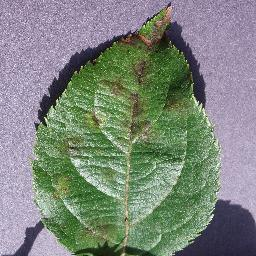

In [25]:
# mostramos la imagen y el label con nombre
print(IDX2CLASS[sample_label])
to_pil_image(sample_img)

In [26]:
dl_train = DataLoader(
    dataset_train,
    batch_size=BATCH_SZ_TRAIN,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    #collate_fn=collate_fn
)

dl_valid =  DataLoader(
    dataset_valid,
    batch_size=BATCH_SZ_VALID,
    num_workers=1,
    pin_memory=True,
    #collate_fn=collate_fn
)

dl_test =  DataLoader(
    dataset_test,
    batch_size=BATCH_SZ_TEST,
    num_workers=1,
    pin_memory=True,
    #collate_fn=collate_fn
)

In [27]:
next(iter(dl_valid))[0].shape

torch.Size([128, 3, 256, 256])

# Modelo simple

In [50]:
def conv_block(c_in, c_out, k=3, p='same', s=1, dropout_p = 0):
    block = nn.Sequential(
        nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    if dropout_p > 0:
        block.append(nn.Dropout2d(p=dropout_p, inplace=False))

    return block

In [51]:
class SimpleCNN(torch.nn.Module):
  def __init__(self, channels_dropout_list):
    super().__init__()
    c_in = 3
    self.conv_blocks = nn.Sequential()
    for c_out, k, drop_p in channels_dropout_list:
        self.conv_blocks.append(conv_block(c_in=c_in, c_out=c_out, k=k, dropout_p=drop_p))
        c_in = c_out
    dim = 256 >> len(self.conv_blocks) # son 256x256 así que dim es 256 // 2**(#maxpools)
    self.fc = torch.nn.Linear(c_in*dim**2, 38)


  def forward(self, x):
    # conv stage
    x = self.conv_blocks(x)

    # flatten
    x = x.flatten(start_dim=1)

    # FC head
    return self.fc(x)

In [52]:
# deteccion de GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

In [70]:
config1 = [
    (32,3,0.1),
    (64,3,0.1),
    (128,3,0.1),
    (64,3,0.1),
]

cnn1 = SimpleCNN(config1).to(device)
opt1 = torch.optim.Adam(cnn1.parameters(), lr=LR)

cnn1

SimpleCNN(
  (conv_blocks): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout2d(p=0.1, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout2d(p=0.1, inplace=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout2d(p=0.1, inplace=False)
    )
    (3): Sequential(
      (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): D

In [86]:
# M params
sum(p.numel() for p in cnn1.parameters()) / 1e6

0.78967

In [72]:
# M params EfficientNet_B0 (deberían ser ~5M)
effnet = efficientnet_b0(weights=None)
sum(p.numel() for p in effnet.parameters()) / 1e6

5.288548

## Utils para train & test

Vamos a medir:

* *accuracy* como medida global de performance
* *macro-averaged F1* como medida de balance entre recall y precision, ajustado por desbalance del dataset
* *cross entropy* para comparación entre valores de loss de splits no-train

In [73]:
def predict(model, device, dataloader):
    all_preds = torch.empty((len(dataloader.dataset),N_CLASSES))
    all_targets = torch.empty(len(dataloader.dataset), dtype=int)

    # get all preds
    running_idx = 0
    with torch.no_grad():
        for imgs, targets in dataloader:

            next_idx = running_idx + len(imgs)

            all_targets[running_idx:next_idx] = targets

            preprocessed = imgs.to(device)

            all_preds[running_idx:next_idx,:] = model(preprocessed).cpu().detach()

            running_idx = next_idx

    return all_preds, all_targets

In [74]:
def evaluate(model, device, dataloader):
    model.eval()
    with torch.no_grad():
        all_preds, all_targets = predict(model, device, dataloader)

        # measure macro-avg F1, accuracy
        #print(all_preds.shape, all_targets.shape)
        loss = F.cross_entropy(all_preds, all_targets).item()
        y_pred = all_preds.argmax(-1).numpy()
        y_true = all_targets.numpy()
        acc = accuracy_score(y_true, y_pred)
        f1_macro = f1_score(y_true, y_pred, average='macro')

    return {
        'valid_loss': loss,
        'accuracy': acc,
        'F1': f1_macro
    }

In [75]:
# mostramos uso
evaluate(cnn1, device, dl_valid)

{'valid_loss': 3.6370489597320557,
 'accuracy': 0.03175189219124977,
 'F1': 0.0026801960295138377}

In [76]:
def train_one_epoch(model, optimizer, device, dataloader, scheduler = None, running_lambda = 0.9):
    model.train()
    running_avg = 0.0
    for imgs, targets in dataloader:
        preds = model(imgs.to(device))

        optimizer.zero_grad()

        loss = F.cross_entropy(preds, targets.to(device))

        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        # EMA de los valores de loss en train, por batch
        running_avg = running_lambda * running_avg + (1-running_lambda) * loss.cpu().detach().item()

    # devolvemos el EMA rescaleado
    return running_avg / (1-running_lambda**len(dataloader))

In [77]:
# ciclo de train
def train(
        model, epochs, device, train_valid_dataloaders,
        optimizer, scheduler = None, running_lambda = 0.9,
        verbose = True,
        patience = -1, early_stopping_metric = 'valid_loss'):
    train_dl, valid_dl = train_valid_dataloaders

    historics = list()

    best_valid_loss = np.inf
    running_patience = patience

    for epoch in range(epochs):
        # train
        t1 = time.time()
        train_loss = train_one_epoch(model, optimizer, device, train_dl, scheduler, running_lambda)
        t2 = time.time()
        if verbose:
            print(f"{epoch+1:>2}/{epochs} epochs | TRAIN | {t2-t1:5.2f} secs | train EMA loss: {train_loss:.4f}")

        # valid
        valid_metrics = evaluate(model, device, valid_dl)
        t3 = time.time()
        if verbose:
            print(f"{epoch+1:>2}/{epochs} epochs | VALID | {t3-t2:5.2f} secs |",", ".join([f"{k}:{v:.3f}" for k,v in valid_metrics.items()]))
        valid_metrics['train_loss'] = train_loss

        historics.append(valid_metrics)

        # patience
        if patience > 0:
            if valid_metrics[early_stopping_metric] < best_valid_loss:
                # update new best, reset patience
                best_valid_loss = valid_metrics[early_stopping_metric]
                running_patience = patience
            else:
                # no new best, countdown on patience, maybe break
                running_patience -= 1
                if running_patience == 0:
                    print("Breaking due to exhausted patience")
                    break

    return pd.DataFrame(historics)

## Entrenamiento

In [78]:
results_df = train(
    model = cnn1,
    epochs = EPOCHS,
    device = device,
    optimizer = opt1,
    train_valid_dataloaders = (dl_train, dl_valid),
    patience = 2
)

 1/10 epochs | TRAIN | 96.01 secs | train EMA loss: 1.0928
 1/10 epochs | VALID | 11.78 secs | valid_loss:0.966, accuracy:0.714, F1:0.623
 2/10 epochs | TRAIN | 94.50 secs | train EMA loss: 0.8315
 2/10 epochs | VALID | 11.11 secs | valid_loss:0.692, accuracy:0.799, F1:0.732
 3/10 epochs | TRAIN | 95.08 secs | train EMA loss: 0.5775
 3/10 epochs | VALID | 11.76 secs | valid_loss:0.495, accuracy:0.850, F1:0.804
 4/10 epochs | TRAIN | 95.35 secs | train EMA loss: 0.4984
 4/10 epochs | VALID | 11.68 secs | valid_loss:0.430, accuracy:0.867, F1:0.818
 5/10 epochs | TRAIN | 95.52 secs | train EMA loss: 0.4262
 5/10 epochs | VALID | 11.19 secs | valid_loss:0.394, accuracy:0.875, F1:0.830
 6/10 epochs | TRAIN | 95.11 secs | train EMA loss: 0.3646
 6/10 epochs | VALID | 11.82 secs | valid_loss:0.382, accuracy:0.878, F1:0.833
 7/10 epochs | TRAIN | 95.32 secs | train EMA loss: 0.2691
 7/10 epochs | VALID | 11.84 secs | valid_loss:0.358, accuracy:0.890, F1:0.861
 8/10 epochs | TRAIN | 95.23 secs 

In [79]:
# mostramos el dataframe de metricas

results_df

,valid_loss,accuracy,F1,train_loss
0,0.965673,0.713679,0.622604,1.092795
1,0.692340,0.799151,0.732023,0.831472
2,0.494749,0.850471,0.803654,0.577512
3,0.429935,0.866900,0.818281,0.498445
4,0.394417,0.875208,0.830352,0.426213
5,0.381777,0.877608,0.833261,0.364618
6,0.358400,0.889976,0.861020,0.269126
7,0.326458,0.896622,0.858178,0.292945
8,0.329015,0.897914,0.864570,0.206359
9,0.312790,0.902714,0.869905,0.203356


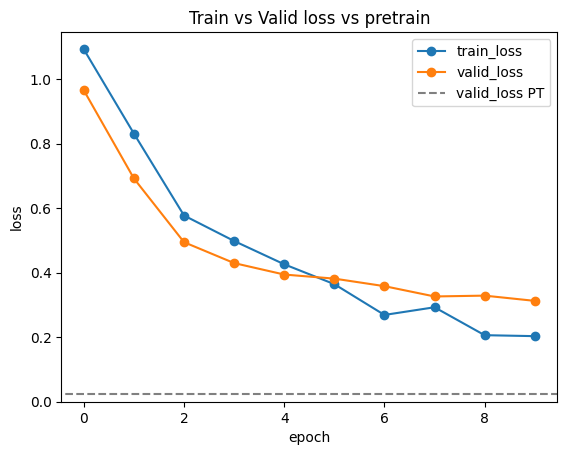

In [80]:
# graficamos loss de train y valid por epoch

ax = results_df[['train_loss','valid_loss']].plot(marker='o', linestyle='-')
aux = ax.get_xlim()
ax.hlines(0.024, -10, 20, color='gray', linestyle='dashed', label='valid_loss PT')
ax.set_xlim(*aux)
ax.set_title('Train vs Valid loss vs pretrain')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_ylim(bottom=0)
ax.legend(loc='upper right')
plt.show()

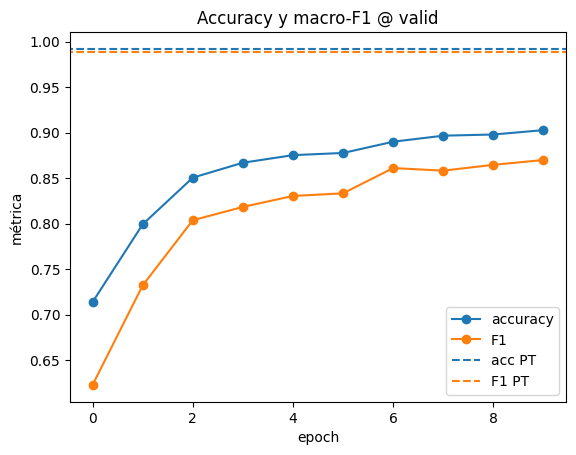

In [81]:
ax = results_df[['accuracy','F1']].plot(marker='o', linestyle='-')
aux = ax.get_xlim()
ax.hlines(0.992, -10, 20, color='tab:blue', linestyle='dashed', label='acc PT')
ax.hlines(0.9886, -10, 20, color='tab:orange', linestyle='dashed', label='F1 PT')
ax.set_xlim(*aux)
ax.set_title('Accuracy y macro-F1 @ valid')
ax.set_xlabel('epoch')
ax.set_ylabel('métrica')
ax.legend(loc='lower right')
#ax.set_ylim(0.9,1)
plt.show()

In [82]:
# rompe un poco DRY, pero no afecta tanto
evaluate(cnn1, device, dl_test)

{'valid_loss': 0.35854557156562805,
 'accuracy': 0.9001928197594344,
 'F1': 0.8670519745713577}

In [83]:
# corremos sobre test
test_preds, test_targets = predict(cnn1, device, dl_test)

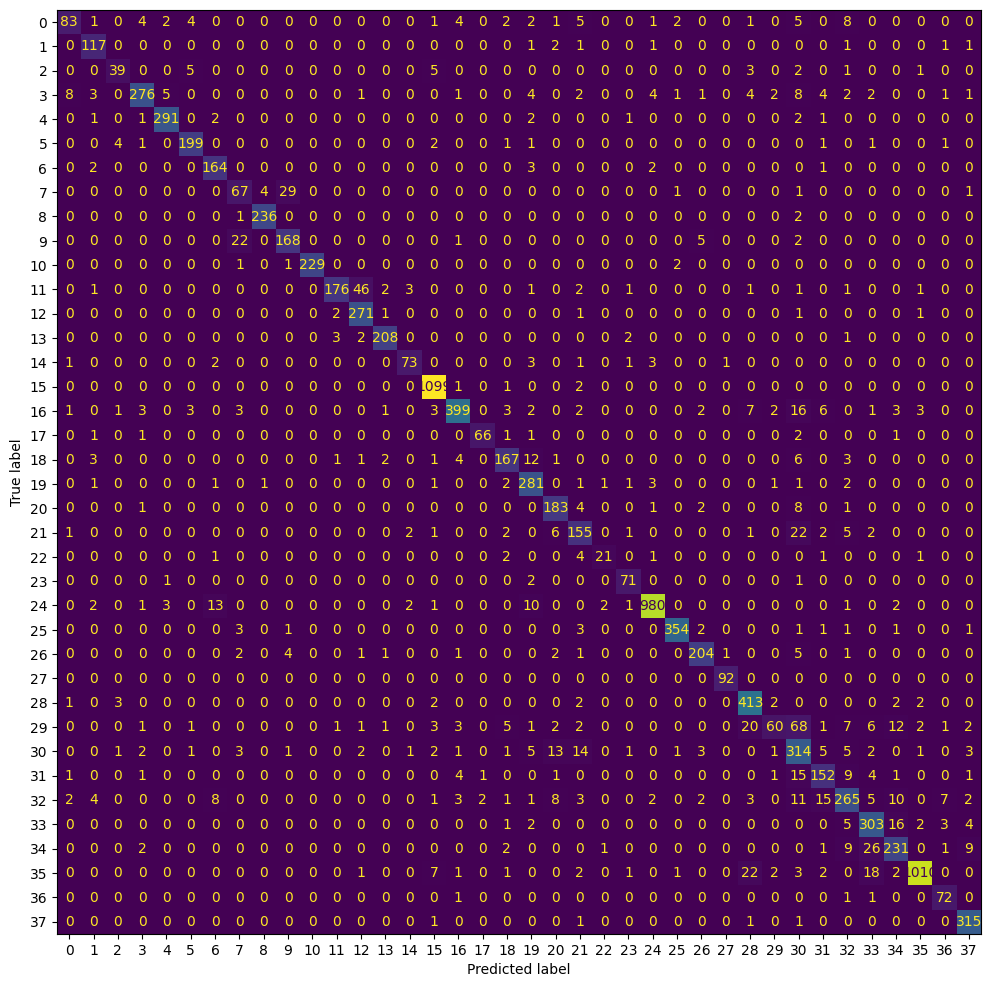

In [84]:
# matriz de confusion usando el argmax

test_argmaxes = test_preds.argmax(-1)

fig, ax = plt.subplots(figsize=(12,12))
ConfusionMatrixDisplay.from_predictions(
   test_targets, test_argmaxes,
   ax=ax,
   colorbar=False,
)
plt.show()

Conclusiones:

El modelo aprende pero la falta de parámetros afecta en la expresividad y se nota. Dicho eso, un training set de 38k observaciones hace mucha fuerza.